In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
from dropletsProject.vectorsAndConstants import *
from dropletsProject.utilityFunctions import *
import matplotlib
import matplotlib.pyplot as plt
import re

In [2]:
pappu_a: pd.DataFrame = pd.read_excel(pathPappuA, sheet_name=0, header=[3])
# Selecting the columns of interest
pappu_a: pd.DataFrame = pappu_a.iloc[:, 1:17]
display(pappu_a.head())

# Renaming columns
pappu_columns: List[str] = renameColumns(pappu_a)


pappu_a.columns = ['Size'] + pappu_columns

,Size (nm),0.125 μM,Unnamed: 3,Unnamed: 4,0.25 μM,Unnamed: 6,Unnamed: 7,0.5 μM,Unnamed: 9,Unnamed: 10,1 μM,Unnamed: 12,Unnamed: 13,2 μM,Unnamed: 15,Unnamed: 16
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15,226059,0,0,44266,0,0,90795,0,40964,0,0,0,0,0,0
2,25,1022404,185926,176869,637429,594488,485078,953347,834614,475181,45768,36957,84194,916456,423718,233628
3,35,1443696,617540,214104,2363798,2268963,2098707,4103932,2561687,2916626,816193,997847,1494445,2726831,1618465,1588671
4,45,760381,703863,1470804,7179925,7867058,5415059,11667153,9750937,8192770,3951288,3865732,2967841,7767336,5890381,4679236


In [3]:
k_array_lines_a, k_array_std_a = k_array_lines_pappu(
    pappu_a, pappu_a_conc, k_to_try_pappu)


def keysTail(i: int) -> List[float]:
    return (tail << fC >> strToFloat)(k_array_lines_a[i].keys())


def valuesTail(i: int) -> List[float]:
    return (tail << fC >> list)(k_array_lines_a[i].values())

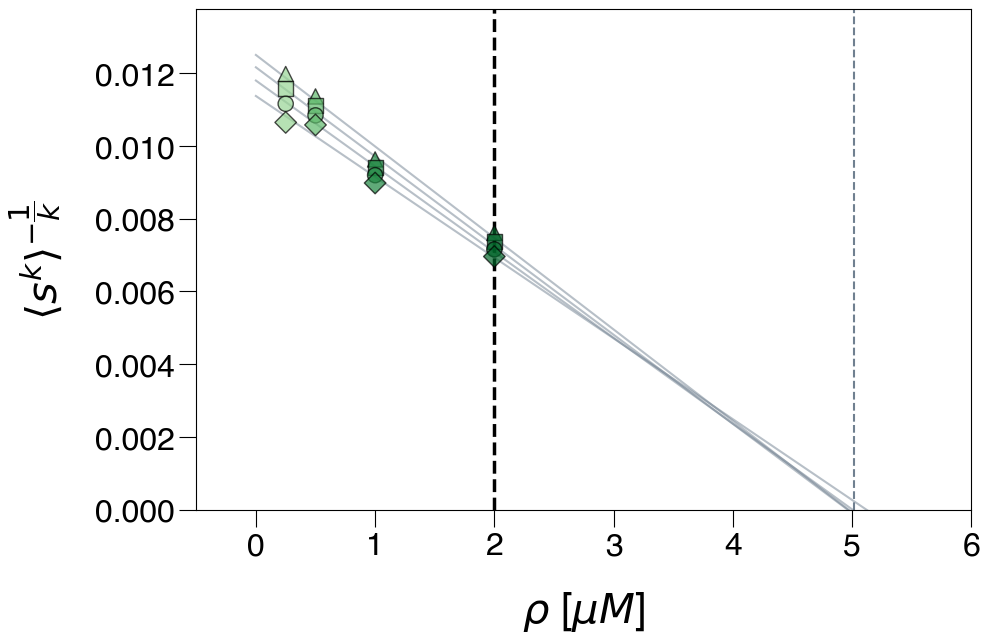

In [4]:
setFontMatplotlib()
fig, ax = createCanvas()
slopes_a: dict = {}
intercepts_a: dict = {}
r_a: dict = {}
se_a: dict = {}
rho_c_a_list: List[float] = []
var_list_a: List[float] = []

n_colors: int = len(pappu_a_conc) - 1
colors_perc: List[float] = [0.4, 0.55, 0.77, 0.9]
colors: dict = {conc: cmapPappuA(
    colors_perc[i]) for i, conc in enumerate(tail(pappu_a_conc))}
x_axis: np.array = np.linspace(0, 10, 1000)
for i in range(len(k_to_try_pappu)):
    ax.scatter(keysTail(i), valuesTail(i), color=list(colors.values()), alpha=0.7,
               marker=markersDead[i], label=f'k = {k_to_try_pappu[i]}', zorder=4, s=120, edgecolors='black')

    slope, intercept, r, _, se = linregress(keysTail(i), valuesTail(i))
    popt, pcov = curve_fit(line, keysTail(i), valuesTail(i))
    var_list_a.append(varPropagationDead(*(list(popt) + list(np.diag(pcov)))))
    slopes_a[k_to_try_pappu[i]] = slope
    intercepts_a[k_to_try_pappu[i]] = intercept
    r_a[k_to_try_pappu[i]] = r
    se_a[k_to_try_pappu[i]] = se
    rho_c_a_list.append(- intercept / slope)
    ax.plot(x_axis, slope * x_axis + intercept, label=f'k = {k_to_try_pappu[i]} fit', color='slategrey',
            alpha=0.5, zorder=2)
ax.axvline(critical_c_a, color='black', linestyle='--',
           label='Critical concentration', linewidth=2.5)
final_rho_c_a: float = np.mean(rho_c_a_list)
ax.axvline(final_rho_c_a, color='slategrey',
           linestyle='--', label='Critical concentration')
ax.set_ylim(bottom=0)
ax.set_xlim(right=6)
ax.set_xlabel('$\\rho$ [$\mu M$]', fontsize=30, labelpad=20)
ax.set_ylabel(
    '$ \left <  s^{k} \\right >^{-\dfrac{1}{k}} $', fontsize=30, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=23, length=12)

# ax.set_title('Estimation of the critical concetration - Pappu A', fontsize = 20, pad = 20)
# fig.savefig('../../paperPlots/pdfPlots/Fig4B.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
# fig.savefig('../../paperPlots/svgPlots/Fig4B.svg', dpi = 300, facecolor = 'white')

In [5]:
y_bar, var = weightedAverage(var_list_a, rho_c_a_list)
final_rho_c_a = np.mean(rho_c_a_list)

In [6]:
ratio_arr_list: List[float] = []
k_mom_list: List[float] = []
k_mom_1_list: List[float] = []
k_mom_std: List[float] = []
k_mom_1_std: List[float] = []
for k in k_to_try_pappu:
    k_mom = dict_moment(pappu_a, pappu_a_conc, k)
    k_mom_list.append(k_mom)
    k_mom_std.append(dict_moment_std(pappu_a, pappu_a_conc, k))
    k_1_mom = dict_moment(pappu_a, pappu_a_conc, k + 1)
    k_mom_1_list.append(k_1_mom)
    k_mom_1_std.append(dict_moment_std(pappu_a, pappu_a_conc, k + 1))

    k_mom_arr = np.array(list(k_mom.values()))
    k_1_mom_arr = np.array(list(k_1_mom.values()))
    ratio_dict = {np.abs((float(conc) - final_rho_c_a)/final_rho_c_a):
                  k_1_mom_arr[i] / k_mom_arr[i]
                  for i, conc in enumerate(pappu_a_conc)}
    ratio_arr_list.append(ratio_dict)

In [7]:
err_dict: dict = {}
for i in range(len(k_to_try_pappu)):
    err_dict[k_to_try_pappu[i]]: dict = {}
    for conc in pappu_a_conc:

        yerr: float = np.sqrt((1 / k_mom_1_list[i][conc])**2 * k_mom_1_std[i][conc] ** 2 +
                              (1 / k_mom_list[i][conc])**2 * k_mom_std[i][conc] ** 2)

        err_dict[k_to_try_pappu[i]][conc] = yerr

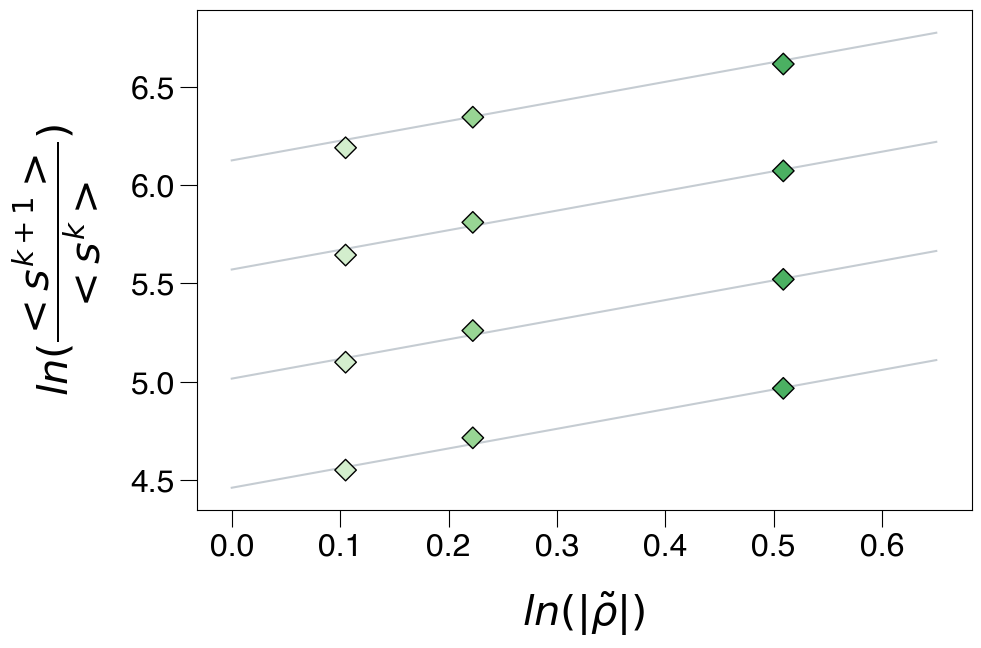

In [8]:
x_axis = np.linspace(-0.65, -0, 100)
fig, ax = createCanvas()
n_colors = len(pappu_a_conc)
colors: dict = {conc: cmapPappuA(np.linspace(0.2, 1, n_colors))[
    i] for i, conc in enumerate(tail2(pappu_a_conc))}
for i, dict_ in enumerate(ratio_arr_list):
    ax.scatter(-tail2(np.log(np.array(list(dict_.keys())))),
               tail2(np.log(np.exp(i/2) * (np.array(list(dict_.values()))))), marker='D', zorder=3,
               color=list(colors.values()), label=f'k = {k_to_try_pappu[i]}', alpha=1,
               edgecolor='black', s=120)

    slope, intercept, r, p, se = linregress(tail2(np.log(np.array(list(dict_.keys())))),
                                            np.log(tail2(np.array(list(dict_.values())))))

    ax.plot(-x_axis, -1 * x_axis + 4.46 + i/1.8,
            color='slategrey', alpha=0.4, zorder=1)


ax.set_xlabel('$ln( | \\tilde{\\rho} |)$', fontsize=30, labelpad=20)
ax.set_ylabel('$ ln(\dfrac{ <s^{k+1}>}{<s^{k}>})$', fontsize=30, labelpad=20)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(axis='both', which='major', labelsize=23, length=12)
# fig.savefig('../../pdfPlots/FigS1a.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
# fig.savefig('../../pdfPlots/FigS1a.svg', dpi = 300, facecolor = 'white')

In [9]:
pappu_a_len: int = len(pappu_a)
dict_df_conc_a: dict = {}
for conc in pappu_a_conc:
    dict_df_conc_a[conc]: pd.DataFrame = pd.DataFrame(columns=[conc])
for _ in range(num_tries):
    mask_dict_a: dict = {}

    for conc in pappu_a_conc:
        mask: np.array = np.zeros((pappu_a_len, 3))
        mask[np.arange(pappu_a_len), np.random.choice(3, pappu_a_len)] = 1
        mask_dict_a[conc] = mask
    masked_pappu_a: dict = {}

    for conc in pappu_a_conc:
        column_idx: int = pappu_a_conc.index(conc)
        columns: np.array = np.array(
            pappu_a)[:, column_idx * 3 + 1: column_idx * 3 + 4]
        columns_masked = np.sum(columns * mask_dict_a[conc], axis=1)
        masked_pappu_a[conc] = columns_masked
    cum_pappu_a: dict = {}

    for conc in pappu_a_conc:
        cum_pappu_a[conc] = 1 - np.insert(np.cumsum(masked_pappu_a[conc]), 0, 0)[
            :-1]/np.sum(masked_pappu_a[conc])
    dataframe_cum_a: pd.DataFrame = pd.DataFrame(cum_pappu_a)

    for conc in pappu_a_conc:
        dict_df_conc_a[conc]: pd.DataFrame = pd.concat(
            [dict_df_conc_a[conc], dataframe_cum_a[conc]], axis=1)
final_cum_dict_a: dict = {}

for conc in pappu_a_conc:
    final_cum_dict_a[conc]: pd.DataFrame = pd.DataFrame(np.nanmean(
        dict_df_conc_a[conc], axis=1), columns=['mean'])
    final_cum_dict_a[conc]['std'] = np.std(dict_df_conc_a[conc], axis=1)

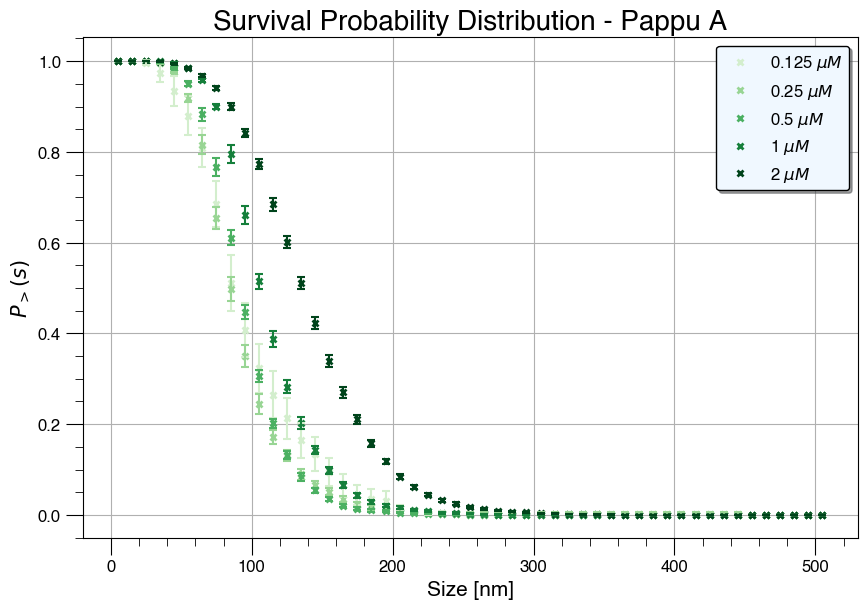

In [10]:
fig, ax = createCanvas()
n_colors = len(pappu_a_conc)
colors = {conc: cmapPappuA(np.linspace(0.2, 1, n_colors))[
    i] for i, conc in enumerate(pappu_a_conc)}
for conc in pappu_a_conc:
    ax.plot(pappu_a['Size'], final_cum_dict_a[conc]['mean'],
            label=f'{conc} $\mu M$', markeredgewidth=2, linestyle='None',
            markersize=5, zorder=4, marker='x', color=colors[conc])

    yerr = final_cum_dict_a[conc]['std']

    ax.errorbar(pappu_a['Size'], final_cum_dict_a[conc]['mean'],
                yerr=yerr, fmt='none', zorder=8, capsize=3, capthick=1.5, color=colors[conc])

ax.set_xlabel('Size [nm]', fontsize=15)
ax.set_ylabel('$P_>(s)$', fontsize=15)
ax.set_title('Survival Probability Distribution - Pappu A', fontsize=20)

ax.grid(zorder=1)

ax.legend(facecolor='aliceblue', fontsize=12, shadow=True, edgecolor='black')

ax.tick_params(axis='both', which='major', labelsize=12, length=12)
ax.tick_params(axis='both', which='minor', labelsize=12, length=6)
ax.minorticks_on()

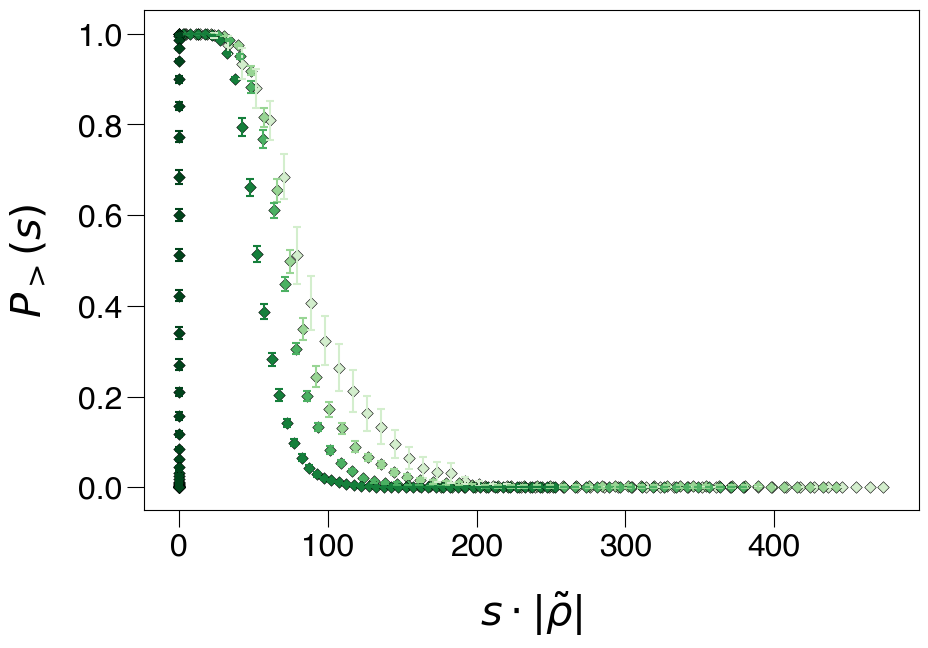

In [11]:
fig, ax = createCanvas()
for conc in pappu_a_conc:
    ax.scatter(np.array(pappu_a['Size']) * np.abs((float(conc) - critical_c_a)/critical_c_a),
               final_cum_dict_a[conc]['mean'], s=35, label=f'{conc} $\mu M$',
               marker='D', color=colors[conc], edgecolor='black', linewidth=0.4)

    yerr: float = final_cum_dict_a[conc]['std']

    ax.errorbar(np.array(pappu_a['Size']) * np.abs((float(conc) - critical_c_a)/critical_c_a),
                final_cum_dict_a[conc]['mean'],
                yerr=yerr, fmt='none', zorder=7, capsize=3, capthick=1.5,
                color=colors[conc], alpha=1)
ax.set_xlabel('$s \cdot  | \\tilde{\\rho}| $', fontsize=30, labelpad=20)
ax.set_ylabel('$P_>(s)$', fontsize=30, labelpad=20)

ax.tick_params(axis='both', which='major', labelsize=23, length=12)
# fig.savefig('../../pdfPlots/Fig4C.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
# fig.savefig('../../pdfPlots/Fig4C.svg', dpi = 300, facecolor = 'white')

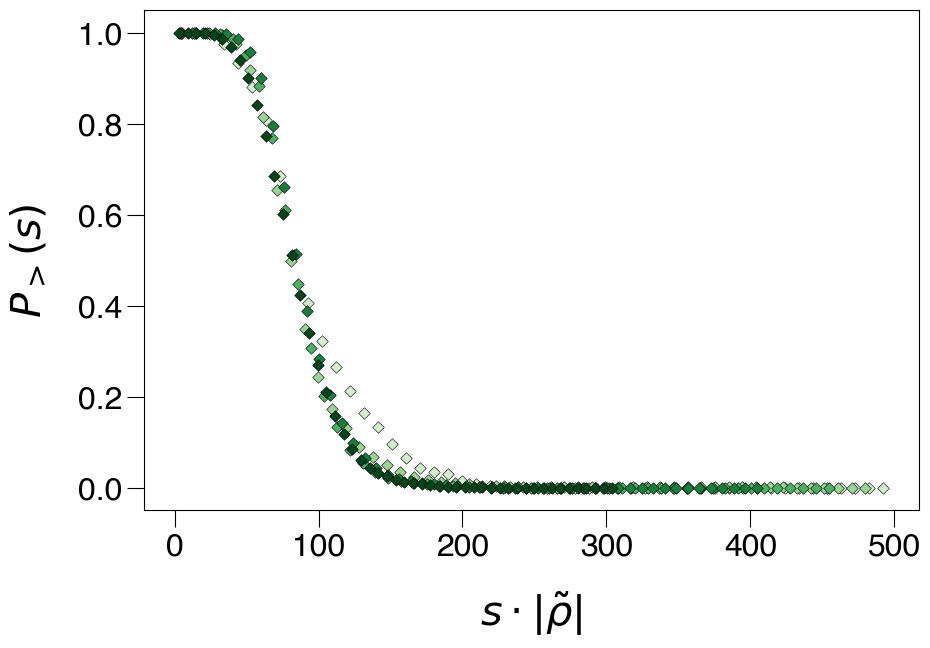

In [12]:
fig, ax = createCanvas()
for conc in pappu_a_conc:
    ax.scatter(np.array(pappu_a['Size']) * np.abs((float(conc)
                                                   - final_rho_c_a)/final_rho_c_a),
               final_cum_dict_a[conc]['mean'],
               label=f'{conc} $\mu M$', edgecolor='black', linewidth=0.4,
               zorder=4, color=colors[conc], marker='D', s=35)

    yerr = final_cum_dict_a[conc]['std']

ax.set_xlabel('$s \cdot  | \\tilde{\\rho}| $', fontsize=30, labelpad=20)
ax.set_ylabel('$P_>(s)$', fontsize=30, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=23, length=12)
# fig.savefig('../../newCollapse1.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
# fig.savefig('../../pdfPlots/Fig4D.svg', dpi = 300, facecolor = 'white')